## Stock Market Prediction using Time-series and Daily News Analysis

### Preprocessing and Modeling

In [13]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,6

pd.set_option('mode.chained_assignment', 'raise') # Raise an exception, warn, or no action if trying to use chained assignment

In [14]:
# Read the combines stock index CSV data file from the data directory
dataset = pd.read_csv('data/comb_data_final.csv',index_col='Date',parse_dates=True)

In [15]:
# Set the threshold two years before the last date (at the beginning of 7th year)
threshold = dataset.index.max() - pd.DateOffset(years=2) 
# Create Train and Test datasets
X_train = dataset[dataset.index <= threshold]['Adj Close']
X_test = dataset[dataset.index > threshold]['Adj Close']

In [16]:
X_train.shape

(1484,)

In [17]:
# Create a separate dataset
dataset['Adj Close']

Date
2008-08-08    11734.320312
2008-08-11    11782.349609
2008-08-12    11642.469727
2008-08-13    11532.959961
2008-08-14    11615.929688
                  ...     
2016-06-27    17140.240234
2016-06-28    17409.720703
2016-06-29    17694.679688
2016-06-30    17929.990234
2016-07-01    17949.369141
Name: Adj Close, Length: 1989, dtype: float64

In [18]:
y = dataset['Adj Close']
type(y)
y.describe().apply("{0:.3f}".format)

count     1989.000
mean     13463.032
std       3144.007
min       6547.050
25%      10913.380
50%      13025.580
75%      16478.410
max      18312.391
Name: Adj Close, dtype: object

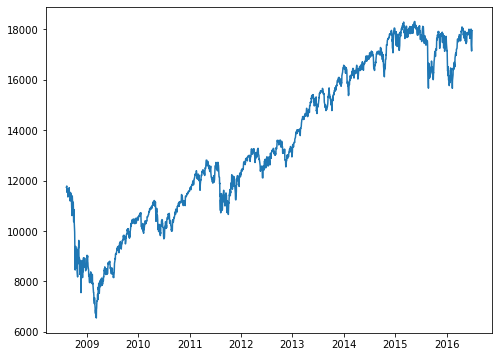

In [19]:
#Lets plot the training dataset
plt.figure(figsize=(8, 6))
plt.plot(y)

# We can see an upward trend, but no abvious seasonality

<Figure size 576x432 with 0 Axes>

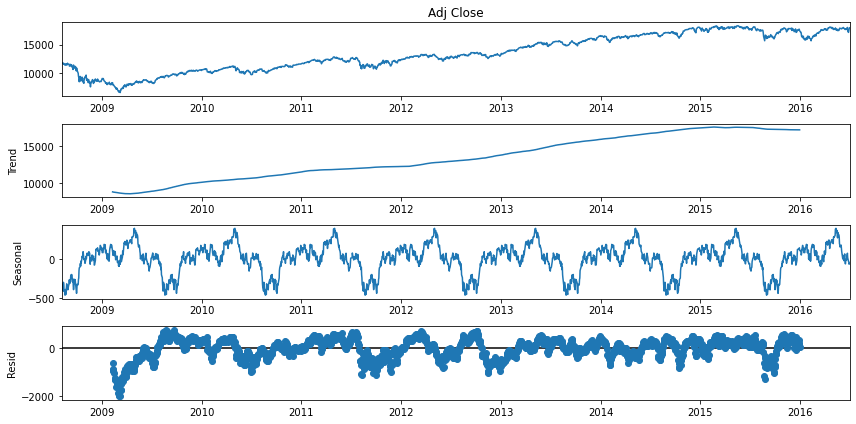

In [42]:
# CHECK for seasonality and trend
# how do we set the period??
# There are 5 trading days in a week, 20 trading days per month, and 253 per year 
result = sm.tsa.seasonal_decompose(y, model='additive', period=253)
plt.figure(figsize=(8, 6))
result.plot()  ;

In [43]:
# Check if price series is stationary usin AdFuller test
# Null hypothesis is that the time series is non-stationary
result = adfuller(y) # the dataset has no NaN values, so no need to .dropna()
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# The result tells us the data is indeed non-stationary since we cannot reject null hypothesis as p is higher than 0.05 significance level

ADF Statistic: -0.3747127512973612
p-value: 0.9142360000847192


In [44]:
# Optional kpss method to check stationarity
from statsmodels.tsa.stattools import kpss
kpss(y)

C:\ProgramData\Miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1881: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(7.146903208807145,
 0.01,
 26,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

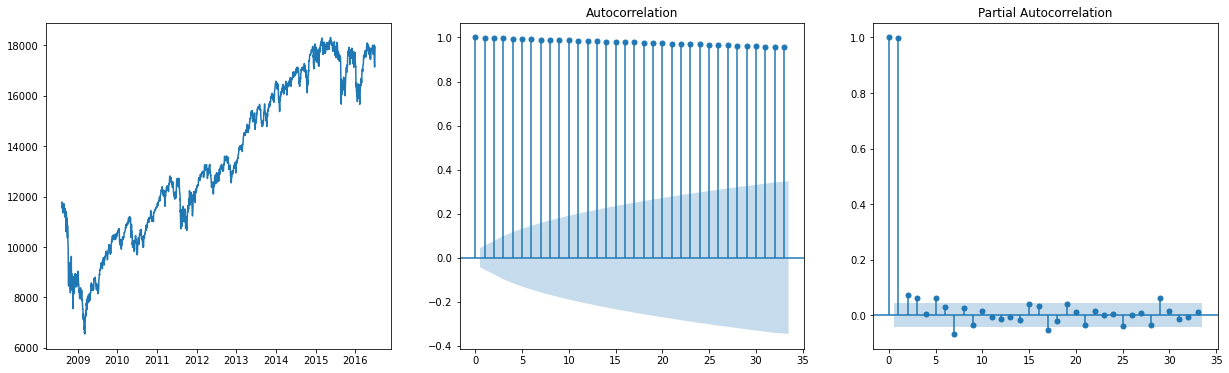

In [12]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21,6))
ax1.plot(y)
plot_acf(y, ax = ax2)
plot_pacf(y, ax = ax3)
plt.show()

### In our plot, we can see that both the mean and the variance increase as time progresses. To get rid of changing variance, we will take the natural log of all the values in our dataset and to get to a constant mean, we will use differencing.

In [46]:
y_stationary = np.log(y).diff().dropna()

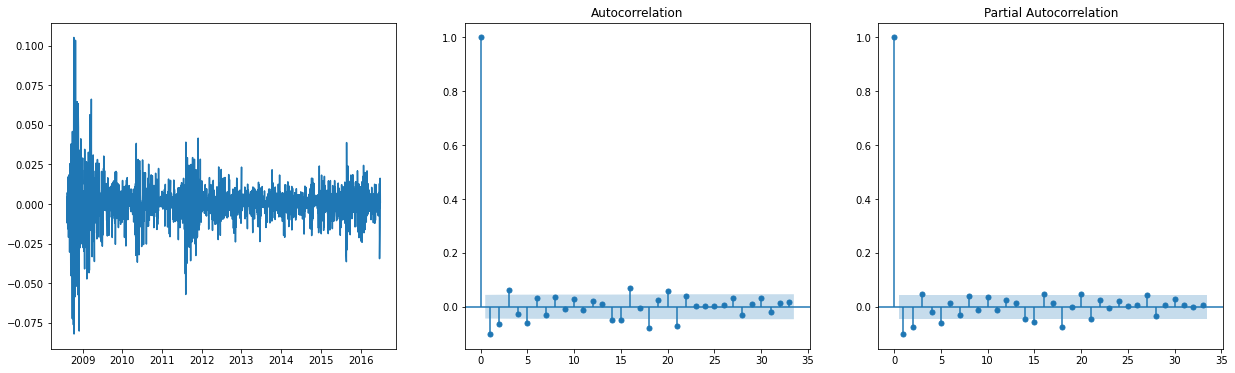

In [47]:
# First differencing: This helps us to determine the value of d which is 1 in this case
# It looks like the returns (differenced data) is randomly distributed around the mean of 0
# indicating stationarity
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21,6))
ax1.plot(y_stationary)
plot_acf(y_stationary, ax = ax2)
plot_pacf(y_stationary, ax = ax3)
plt.show()

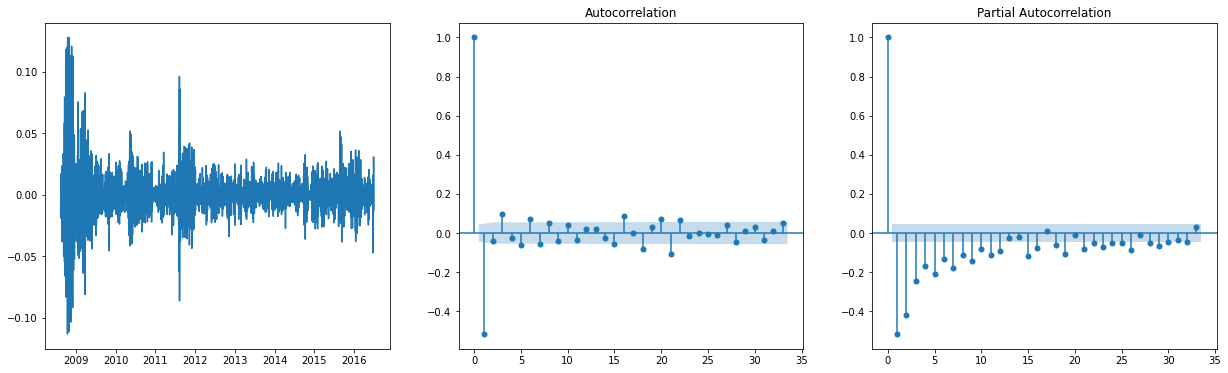

In [48]:
# OPTIONAL
# Twice differencing indicates over-differencing due to the sudden drop in autocorrelation
diff1 = y_stationary.diff().dropna()
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21,6))
ax1.plot(diff1)
plot_acf(diff1, ax = ax2)
plot_pacf(diff1, ax = ax3)
plt.show()

In [49]:
# Let's confirm our finding that the stationarity of the differenced data with the adfuller test:
result2 = adfuller(y_stationary) # 
print(f'ADF Statistic: {result2[0]}')
print(f'p-value: {result2[1]}')

# Since the test statistic is less than the significance level, we can reject the null hypothesis and we can assume that the series is stationary

ADF Statistic: -10.401510921606933
p-value: 1.904073240151235e-18


In [51]:
# OPTIONAL with just differencing
result3 = adfuller(y.diff().dropna()) 
print(f'ADF Statistic: {result3[0]}')
print(f'p-value: {result3[1]}')

ADF Statistic: -10.116266557170404
p-value: 9.706086912817664e-18


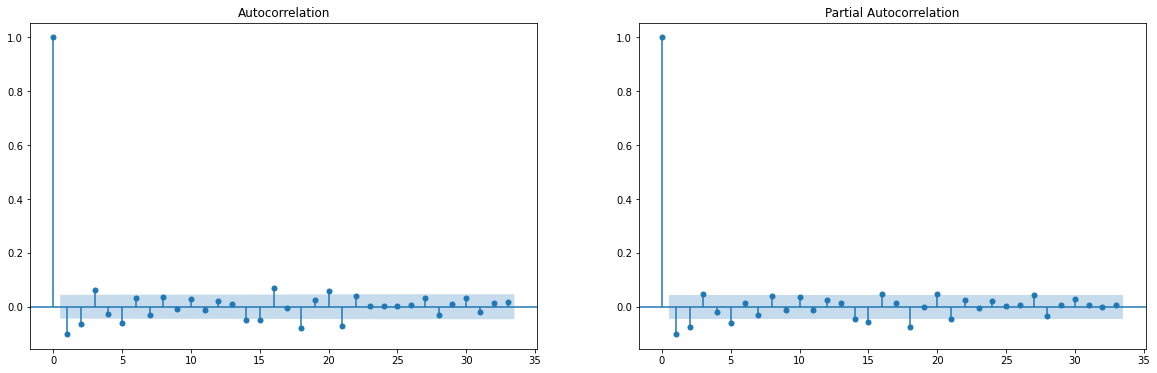

In [53]:
# Visualize the ACF and PACF plots of the stationarized series.
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 6))
plot_acf(y_stationary, ax = ax1)
plot_pacf(y_stationary, ax = ax2)
plt.show()

By looking at the PACF of the stationarized series, we can conclude that the p (order of AR model) could be 2 since that is the lag that stands above the significance line.<br>
For the q order term (MA), we review the ACF plot and conclude to be 2 as well.
However, we will use the ARIMA model to find the optimum values of p and q.

## Arima Model
ARIMA (Auto Regressive Integrated Moving Average) is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.

ARIMA model has 3 parameters:

p - the parameter associated with the Auto-Regressive part of the ARIMA model. You can use the PACF (partial autocorrelation function) plot to find the optimal value.

d - the parameter associated with the Integration part of the ARIMA model. This is the order of difference, or the number of times the time series is differenced in order to stationarize the series.

q - the parameter associated with the Moving Average part of the ARIMA model. You can use the ACF (autocorrelation function) plot to find the optimal value.

### Model Fitting

In [96]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.statespace.sarimax import SARIMAX

#### Make a function to find the MSE of a single ARIMA model

In [190]:
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model 
def evaluate_arima_model(data, arima_order):
    # Make train and test variables, with 'train, test'
    train, test = data[0:1484], data[1484:len(data)]
    past=[x for x in train]
    # make predictions. Declare a variable with that name
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        # Append() here
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error

#### Make a function to evaluate the different ARIMA models with different p, d, and q values

In [191]:
# Make a function called evaluate_models to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p,d,q)
                try:
                    # Make a variable called mse for the Mean squared error
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.2E' % (order,mse)) # format is changed to scientific notation instead of decimals
                except:
                    continue
    return print('Best ARIMA%s MSE=%.2E' % (best_cfg, best_score))

In [192]:
# Now, we choose a couple of values to try for each parameter: p_values, d_values and q_values
# Fill in the blanks as appropriate
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

In [193]:
# We can find the optimum ARIMA model for our data.
evaluate_models(y_stationary, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=8.42E-05
ARIMA(0, 0, 1) MSE=8.51E-05
ARIMA(0, 0, 2) MSE=8.51E-05
ARIMA(0, 1, 0) MSE=1.72E-04
ARIMA(0, 1, 1) MSE=8.48E-05
ARIMA(0, 1, 2) MSE=8.56E-05
ARIMA(0, 2, 0) MSE=5.17E-04
ARIMA(0, 2, 1) MSE=1.72E-04
ARIMA(0, 2, 2) MSE=8.66E-05
ARIMA(1, 0, 0) MSE=8.49E-05
ARIMA(1, 0, 1) MSE=8.50E-05
ARIMA(1, 1, 0) MSE=1.29E-04
ARIMA(1, 1, 1) MSE=8.59E-05
ARIMA(1, 2, 0) MSE=2.88E-04
ARIMA(2, 0, 0) MSE=8.53E-05
ARIMA(2, 0, 1) MSE=8.54E-05
ARIMA(2, 1, 0) MSE=1.15E-04
ARIMA(2, 1, 2) MSE=8.62E-05
ARIMA(2, 2, 0) MSE=2.11E-04
Best ARIMA(0, 0, 0) MSE=8.42E-05


### The above process did not result in anything useful!!!

### Should I be trying on the full dataset or the training?

In [127]:
# SOLUTION 2: Use auto_arima method from pmdarima library
import pmdarima as pm
model1 = pm.auto_arima(y_stationary, # data
                    d=0, # non-seasonal difference order
                    start_p=0, # initial guess for p
                    start_q=0, # initial guess for q
                    max_p=3, # max value of p to test
                    max_q=3, # max value of q to test
                    )
model1.summary() # SARIMAX(3, 0, 0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1988
Model:               SARIMAX(3, 0, 0)   Log Likelihood                5885.943
Date:                Thu, 21 Jan 2021   AIC                         -11763.886
Time:                        15:42:54   BIC                         -11741.506
Sample:                             0   HQIC                        -11755.666
                               - 1988                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1052      0.013     -8.241      0.000      -0.130      -0.080
ar.L2         -0.0706      0.010     -7.256      0.000      -0.090      -0.052
ar.L3          0.0476      0.013      3.752      0.000       0.023       0.072
sigma2         0.0002   2.25e-06     69.650      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7047.90
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [129]:
# OPTIONAL: np.log(y)
model1 = pm.auto_arima(np.log(y), # data
                    d=1, # non-seasonal difference order - added 1 differencing for this one
                    start_p=0, # initial guess for p
                    start_q=0, # initial guess for q
                    max_p=3, # max value of p to test
                    max_q=3, # max value of q to test
                    )
model1.summary() # result SARIMAX(2, 1, 2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1989
Model:               SARIMAX(2, 1, 2)   Log Likelihood                5887.073
Date:                Thu, 21 Jan 2021   AIC                         -11764.147
Time:                        15:44:32   BIC                         -11736.172
Sample:                             0   HQIC                        -11753.872
                               - 1989                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3996      0.100     -3.991      0.000      -0.596      -0.203
ar.L2         -0.3938      0.068     -5.751      0.000      -0.528      -0.260
ma.L1          0.2913      0.104      2.813      0.005       0.088       0.494
ma.L2          0.2962      0.074      3.990      0.000       0.151       0.442
sigma2         0.0002   2.28e-06     68.754      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              7100.09
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Let me try on Training/Test

In [182]:
train = dataset[:1484]
test = dataset[1484:]

training = train['Adj Close']
validation = test['Adj Close']

In [132]:
# Ignore seasonality to build auto_arima
model1 = pm.auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, 
start_P=0,start_Q=0, max_P=3, max_Q=3, 
seasonal=False, 
d=0, D=0, 
trace=True,error_action='ignore',suppress_warnings=True)

# ARIMA(1,0,3) model seems to be the best without differencing

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=18849.370, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=32182.278, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=18862.266, Time=0.60 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=18848.479, Time=0.56 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.79 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=18851.873, Time=0.53 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=18848.234, Time=0.83 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=2.57 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=18849.647, Time=1.01 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=18850.980, Time=0.71 sec

Best model:  ARIMA(1,0,3)(0,0,0)[0]          
Total fit time: 8.577 seconds


In [133]:
# Ignore seasonality to build auto_arima
model2 = pm.auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, 
start_P=0,start_Q=0, max_P=3, max_Q=3, 
seasonal=False, 
d=1, D=1, 
trace=True,error_action='ignore',suppress_warnings=True)

# ARIMA(0,1,3) model seems to be the best with differencing

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=18826.359, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18839.891, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18827.960, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18826.317, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18838.848, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=18825.100, Time=0.41 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=18825.644, Time=0.39 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=18825.095, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=18826.791, Time=0.86 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=18824.274, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=18824.440, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=18826.024, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=18824.939, Time=0.21 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0]          
Total fit time: 3.485 seconds


In [134]:
# Include seasonality of a year to build auto_arima - 12 month seasonality
model3 = pm.auto_arima(training, start_p=1, start_q=1, max_p=3, max_q=3, 
start_P=0,start_Q=0, max_P=3, max_Q=3, 
m=12, d=1, D=1, 
seasonal=True, 
trace=True, error_action='ignore',suppress_warnings=True)

# ARIMA(3,1,0)(3,1,0)[12] model seems to be the best 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=19677.541, Time=0.51 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=19688.574, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=19275.402, Time=0.55 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.97 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=19678.043, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=19077.869, Time=1.09 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=18997.632, Time=2.81 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=10.64 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.51 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=19009.714, Time=2.32 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=18995.711, Time=3.08 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=19075.183, Time=1.64 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=15.21 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=5.22 sec
 ARIMA(3,1,0)(3,1,0)[12]         

### Build a SARIMAX model

In [135]:
# Instantiate model
model_sarimax = SARIMAX(training, order=(3,1,0), seasonal_order=(3,1,0,12))
# Fit model
results_sarimax = model_sarimax.fit()
# Print the results summary
print(results_sarimax.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Adj Close   No. Observations:                 1484
Model:             SARIMAX(3, 1, 0)x(3, 1, 0, 12)   Log Likelihood               -9489.953
Date:                            Thu, 21 Jan 2021   AIC                          18993.905
Time:                                    15:54:39   BIC                          19030.961
Sample:                                         0   HQIC                         19007.723
                                           - 1484                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0998      0.018     -5.426      0.000      -0.136      -0.064
ar.L2         -0.0466      0.016   

In [141]:
forecast = model3.predict(n_periods=505)
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

In [142]:
rmse=np.sqrt(np.mean(np.power((np.array(test['Adj Close'])-np.array(forecast['Prediction'])),2)))
rmse

2782.3342017551486

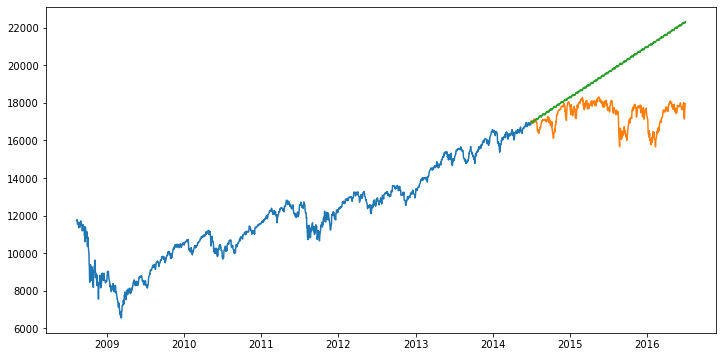

In [143]:
#plot
plt.plot(train['Adj Close'])
plt.plot(test['Adj Close'])
plt.plot(forecast['Prediction'])

### Second Try

In [194]:
# Build ARIMA with recommended order
model_arima = ARIMA(training, order=(0,1,3))
model_fit = model_arima.fit()
forecast = model_fit.predict(505)# ????
fc, se, conf = model_fit.forecast(505, alpha=0.05)  # 95% conf
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                 1483
Model:                 ARIMA(0, 1, 3)   Log Likelihood               -9407.523
Method:                       css-mle   S.D. of innovations            137.639
Date:                Thu, 21 Jan 2021   AIC                          18825.046
Time:                        17:32:30   BIC                          18851.555
Sample:                             1   HQIC                         18834.927
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.5096      3.185      1.102      0.271      -2.734       9.753
ma.L1.D.Adj Close    -0.0991      0.026     -3.827      0.000      -0.150      -0.048
ma.L2.D.Adj Close    -0.

In [195]:
# Make as pandas series
fc_series = pd.Series(fc, index=validation.index)
lower_series = pd.Series(conf[:, 0], index=validation.index)
upper_series = pd.Series(conf[:, 1], index=validation.index)

In [196]:
rmse=np.sqrt(np.mean(np.power((np.array(validation)-np.array(fc_series)),2)))
rmse

894.3433476690957

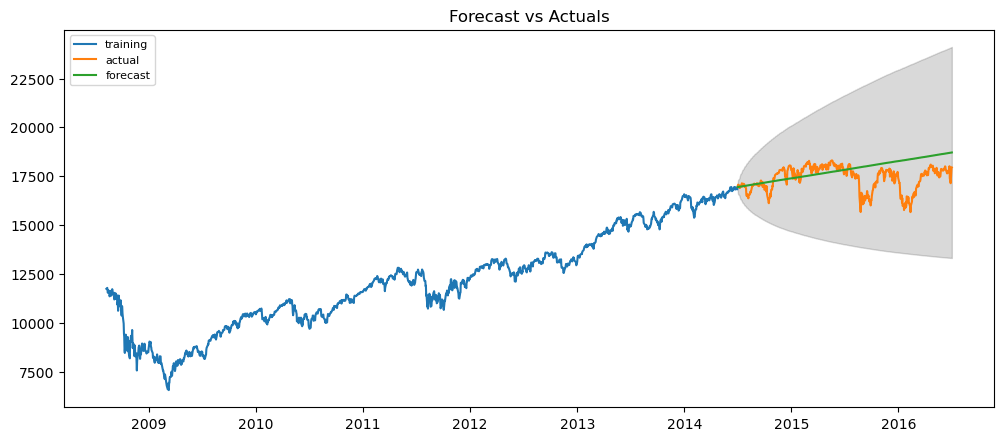

In [197]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(training, label='training')
plt.plot(validation, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()